In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import sys
import pickle
from citymob import import_csv_w_wkt_to_gdf
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar


In [2]:
crs0= 3035 # crs for boundary 
cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria']
ua_year=['2018','2018','2018','2018','2018','2018','2018','2018','2012','2018','2018','2018','2012','2018','2018','2012','2012','2018','2012']
ua_ver=['v013','v013','v013','v013','v013','v013','v013','v013','revised_v021','v013','v013','v013','revised_v021','v013','v013','revised_v021','revised_v021','v013','revised_v021']

In [3]:
city='Dresden'

In [4]:
print('Starting ' + city)
country=countries[cities_all.index(city)]
year=ua_year[cities_all.index(city)]
ver=ua_ver[cities_all.index(city)]

if city=='Potsdam':
    fp='../../MSCA_data/UrbanAtlas/Berlin/Data/Berlin_UA2018_v013.gpkg'

else: 
    fp='../../MSCA_data/UrbanAtlas/' + city + '/Data/' + city + '_UA' + year + '_' + ver +'.gpkg'
gdf=gpd.read_file(fp)

if year =='2012':
    gdf.rename(columns={'class_2012':'class_2018'},inplace=True)

# create urban fabric (residential) and commercial and road land-uses
gdf['Class']='Other'
gdf.loc[gdf['class_2018'].isin(['Discontinuous dense urban fabric (S.L. : 50% -  80%)','Discontinuous medium density urban fabric (S.L. : 30% - 50%)','Discontinuous low density urban fabric (S.L. : 10% - 30%)','Discontinuous very low density urban fabric (S.L. : < 10%)','Continuous urban fabric (S.L. : > 80%)']),'Class']='Urban_Fabric'
gdf.loc[gdf['class_2018'].isin(['Industrial, commercial, public, military and private units','Construction sites','Airports','Port areas']),'Class']='Industrial_Commercial'
gdf.loc[gdf['class_2018'].isin(['Fast transit roads and associated land','Other roads and associated land']),'Class']='Road'

# make a non-road classification, to calculate by reverse the road area
gdf['RoadStatus']='NonRoad'
gdf.loc[gdf['class_2018'].isin(['Fast transit roads and associated land','Other roads and associated land']),'RoadStatus']='Road'


# make an aggregated LU classification, this time distinguishing 'urban' and 'non-urban' areas
gdf['UrbanStatus']='Non-Urban'
gdf.loc[gdf['class_2018'].isin(['Discontinuous dense urban fabric (S.L. : 50% -  80%)',
'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
'Discontinuous very low density urban fabric (S.L. : < 10%)',
'Continuous urban fabric (S.L. : > 80%)',
'Industrial, commercial, public, military and private units',
'Sports and leisure facilities',
'Green urban areas',
'Isolated structures',
'Mineral extraction and dump sites', # should this be included?
'Fast transit roads and associated land',
'Railways and associated land ',
'Airports',
'Other roads and associated land',
'Port areas',
'Construction sites',
]),'UrbanStatus']='Urban'

# Read in boundaries
fp='../outputs/city_boundaries/' + city + '.csv'
gdf_boundary = import_csv_w_wkt_to_gdf(fp,crs=crs0,geometry_col='geometry')
# convert the land-uses to base crs, if different
if gdf.crs!=crs0:
    gdf=gdf.to_crs(crs0)

Starting Dresden


In [5]:
gdf.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,geometry,Class,RoadStatus,UrbanStatus
0,DE,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,828-DE009L2,409.909129,9933.170469,None,40,"MULTIPOLYGON (((4592277.929 3105117.359, 45922...",Urban_Fabric,NonRoad,Urban
1,DE,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,706-DE009L2,281.246324,4685.239982,None,54,"MULTIPOLYGON (((4577176.833 3104502.798, 45771...",Urban_Fabric,NonRoad,Urban
2,DE,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,1226-DE009L2,233.659641,3252.222933,None,22,"MULTIPOLYGON (((4583895.063 3106921.403, 45838...",Urban_Fabric,NonRoad,Urban
3,DE,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,1360-DE009L2,292.610137,5280.004514,None,63,"MULTIPOLYGON (((4585827.848 3109252.225, 45858...",Urban_Fabric,NonRoad,Urban
4,DE,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,2216-DE009L2,454.516410,12810.348334,None,237,"MULTIPOLYGON (((4583473.963 3113943.021, 45834...",Urban_Fabric,NonRoad,Urban


In [6]:
# read in postcodes gdf and isolate to specific city
if country=='Germany':
    fp = "../shapefiles/plz-5stellig.shp/plz-5stellig.shp"
    de_plz = gpd.read_file(fp)
    de_plz=de_plz.to_crs(crs0)
    plz_code=de_plz.plz

    city_poly_fp='../dictionaries/city_postcode_DE.pkl'
    a_file = open(city_poly_fp, "rb")
    city_poly_dict = pickle.load(a_file)

    # if the de_plz codes are string and the city_poly_dict codes are int, then can use de_plz['geocode'].astype('int')
    city_poly=de_plz.loc[(de_plz['plz'].isin(city_poly_dict[city]))]

    # change geocode label 
    if 'plz' in city_poly.columns:
        city_poly.rename(columns={'plz':'geocode'},inplace=True)

C:\Users\peter\AppData\Local\Temp\ipykernel_10296\1610040477.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_poly.rename(columns={'plz':'geocode'},inplace=True)


In [7]:
# calculate postcode area
city_poly['area']=city_poly.area

# restrict land-use data to those within our boundary 
intersect=gpd.overlay(gdf_boundary,gdf,how='intersection')
intersect.drop(columns=['crs','country'],inplace=True)

# make list of postcodes
polylist=city_poly['geocode'].tolist()
# predefine stats
urbfabarea_poly=[]
comarea_poly=[]
roadarea_poly=[]
urbarea_poly=[]

# calculate stats for each postcode in a for loop
for p in polylist:
    poly_gdf1=gpd.overlay(city_poly.loc[city_poly['geocode']==p,], intersect, how='intersection')
    poly_gdf1['area2']=poly_gdf1.area

    urbfabarea_poly1=poly_gdf1.loc[poly_gdf1['Class']=='Urban_Fabric',].groupby('geocode')['area2'].agg('sum')
    if len(urbfabarea_poly1)>0:
        urbfabarea_poly.append(urbfabarea_poly1[0])
    else:
        urbfabarea_poly.append(0)

    comarea_poly1=poly_gdf1.loc[poly_gdf1['Class']=='Industrial_Commercial',].groupby('geocode')['area2'].agg('sum')
    if len(comarea_poly1)>0:
        comarea_poly.append(comarea_poly1[0])
    else:
        comarea_poly.append(0)

    roadarea_poly1=poly_gdf1.loc[poly_gdf1['Class']=='Road',].groupby('geocode')['area2'].agg('sum')
    if len(roadarea_poly1)>0:
        roadarea_poly.append(roadarea_poly1[0])
    else:
        roadarea_poly.append(0)

    urbarea_poly1=poly_gdf1.loc[poly_gdf1['UrbanStatus']=='Urban',].groupby('geocode')['area2'].agg('sum')
    if len(urbarea_poly1)>0:
        urbarea_poly.append(urbarea_poly1[0])  
    else:
        urbarea_poly.append(0)

data={'geocode':polylist,'tot_area':city_poly['area'].tolist(),'urb_fabric_area':urbfabarea_poly,'commercial_area':comarea_poly,'road_area':roadarea_poly,'urban_area':urbarea_poly}

lu_poly=pd.DataFrame(data)
lu_poly['pc_urb_fabric']=lu_poly['urb_fabric_area']/lu_poly['tot_area']
lu_poly['pc_comm']=lu_poly['commercial_area']/lu_poly['tot_area']
lu_poly['pc_road']=lu_poly['road_area']/lu_poly['tot_area']
lu_poly['pc_urban']=lu_poly['urban_area']/lu_poly['tot_area']

lu_poly['pc_urb_fabric_urban']=lu_poly['urb_fabric_area']/lu_poly['urban_area']
lu_poly['pc_comm_urban']=lu_poly['commercial_area']/lu_poly['urban_area']
lu_poly['pc_road_urban']=lu_poly['road_area']/lu_poly['urban_area']

lu_poly.drop(columns=['urb_fabric_area','commercial_area','road_area','urban_area'],inplace=True)
lu_poly['geocode']=lu_poly['geocode'].astype('str')

c:\Users\peter\anaconda3\envs\city_mob_test\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
city_poly

,geocode,note,einwohner,qkm,geometry,area
4291,01705,01705 Freital,38322,40.430239,"POLYGON ((4572443.137 3100589.097, 4572458.386...",4.035764e+07
4307,01156,01156 Dresden,11317,31.752508,"POLYGON ((4571875.427 3110510.512, 4571881.459...",3.169624e+07
4308,01139,01139 Dresden,17555,8.437161,"POLYGON ((4577195.244 3115476.589, 4577216.974...",8.421591e+06
4309,01097,01097 Dresden,14821,3.297752,"POLYGON ((4582008.059 3113025.194, 4582062.627...",3.291464e+06
4310,01219,01219 Dresden,20916,6.948872,"POLYGON ((4583682.505 3109136.101, 4583711.930...",6.935391e+06
4311,01159,01159 Dresden,27666,5.920703,"POLYGON ((4578665.314 3109523.364, 4578794.961...",5.909690e+06
4312,01307,01307 Dresden,23815,3.666117,"POLYGON ((4584095.273 3111851.229, 4584117.865...",3.658999e+06
4313,01157,01157 Dresden,20684,8.063627,"POLYGON ((4576464.189 3112116.855, 4576464.014...",8.048920e+06
4314,01099,01099 Dresden,28018,58.506789,"POLYGON ((4583039.442 3115427.542, 4583056.421...",5.838958e+07
4315,01237,01237 Dresden,15536,4.280867,"POLYGON ((4585911.400 3107055.943, 4586030.439...",4.272397e+06


In [9]:
intersect

,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,Class,RoadStatus,UrbanStatus,geometry
0,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,828-DE009L2,409.909129,9.933170e+03,None,40,Urban_Fabric,NonRoad,Urban,"POLYGON ((4592235.795 3105005.158, 4592164.501..."
1,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,706-DE009L2,281.246324,4.685240e+03,None,54,Urban_Fabric,NonRoad,Urban,"POLYGON ((4577158.183 3104494.131, 4577147.281..."
2,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,1226-DE009L2,233.659641,3.252223e+03,None,22,Urban_Fabric,NonRoad,Urban,"POLYGON ((4583852.931 3106904.481, 4583827.885..."
3,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,1360-DE009L2,292.610137,5.280005e+03,None,63,Urban_Fabric,NonRoad,Urban,"POLYGON ((4585864.992 3109326.402, 4585922.316..."
4,Dresden,DE009L2,11100,Continuous urban fabric (S.L. : > 80%),2020-09,2216-DE009L2,454.516410,1.281035e+04,None,237,Urban_Fabric,NonRoad,Urban,"POLYGON ((4583470.599 3113819.255, 4583366.296..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10874,Dresden,DE009L2,31000,Forests,2020-09,62462-DE009L2,7943.660631,1.800946e+06,None,0,Other,NonRoad,Non-Urban,"POLYGON ((4588007.893 3115533.725, 4588026.367..."
10875,Dresden,DE009L2,31000,Forests,2020-09,62502-DE009L2,3970.609573,7.748269e+05,None,0,Other,NonRoad,Non-Urban,"POLYGON ((4591988.363 3115963.905, 4591962.141..."
10876,Dresden,DE009L2,32000,Herbaceous vegetation associations (natural gr...,2020-09,65098-DE009L2,1788.993785,1.173786e+05,None,0,Other,NonRoad,Non-Urban,"POLYGON ((4582680.759 3116017.936, 4582680.431..."
10877,Dresden,DE009L2,50000,Water,2020-09,65647-DE009L2,1320.523798,1.139275e+05,None,0,Other,NonRoad,Non-Urban,"POLYGON ((4589017.683 3107727.152, 4589087.772..."


<AxesSubplot:>

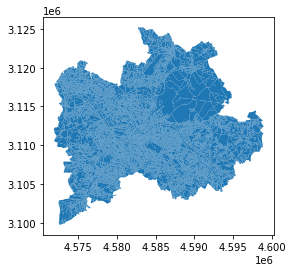

In [18]:
intersect.plot()

<AxesSubplot:>

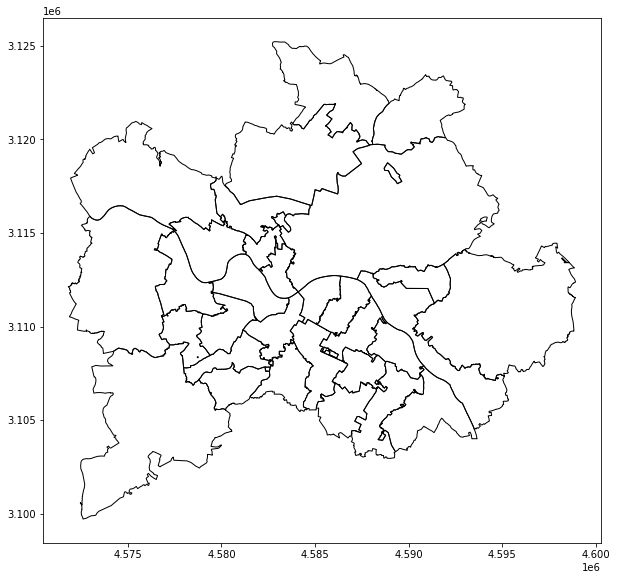

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
city_poly.plot(ax=ax,edgecolor='black',facecolor='None')

<AxesSubplot:>

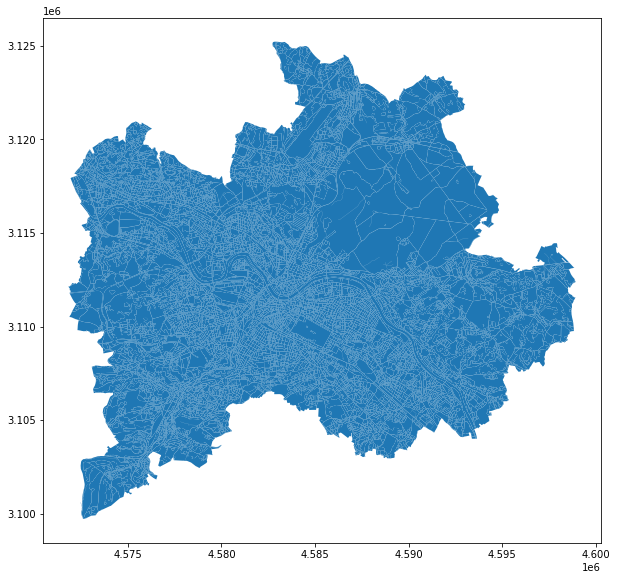

In [28]:

fig, ax = plt.subplots(figsize=(10,10))
intersect.plot(edgecolor='None',ax=ax)

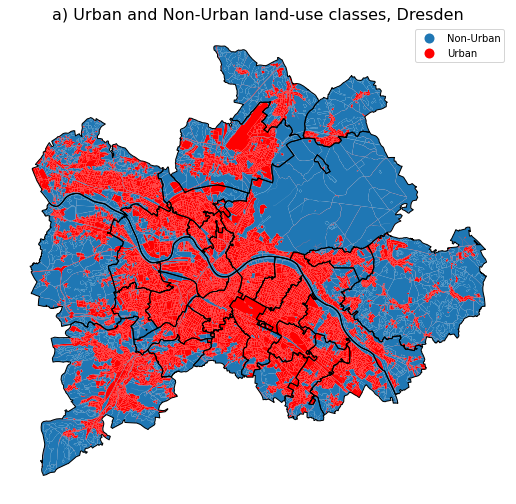

In [14]:
cmap = mpl.colors.ListedColormap(['#1f77b4', 'red'])
fig, ax = plt.subplots(figsize=(9,9))
intersect.plot(column='UrbanStatus',legend=True,ax=ax,cmap=cmap,edgecolor='None')
city_poly.plot(ax=ax,edgecolor='black',facecolor='None') 
ax.set_title("a) Urban and Non-Urban land-use classes, Dresden",size=16)

plt.axis('off'); # this removes the figure frame and the lat/lon coords
plt.savefig('../outputs/LU/LU_demo_Dresden.png',facecolor='w',dpi=300,bbox_inches='tight')


In [10]:
fp='../../MSCA_data/BuildingsDatabase/clips/eubucco_' + city + '.shp' 
buildings_gdf=gpd.read_file(fp)

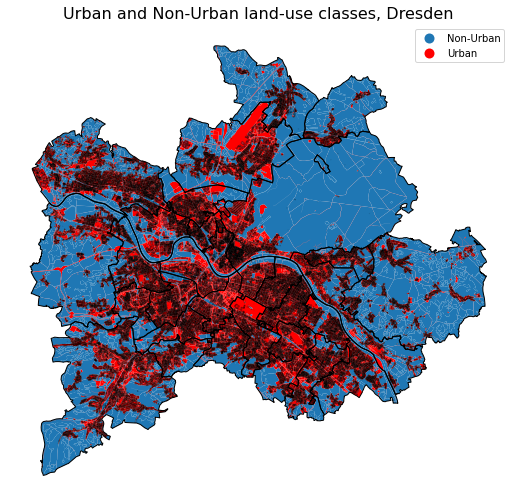

In [58]:
cmap = mpl.colors.ListedColormap(['#1f77b4', 'red'])
fig, ax = plt.subplots(figsize=(9,9))
intersect.plot(column='UrbanStatus',legend=True,ax=ax,cmap=cmap,edgecolor='None')
buildings_gdf.plot(ax=ax,edgecolor='black',alpha=0.3)
city_poly.plot(ax=ax,edgecolor='black',facecolor='None')
ax.set_title("Urban and Non-Urban land-use classes, Dresden",size=16)

plt.axis('off'); # this removes the figure frame and the lat/lon coords

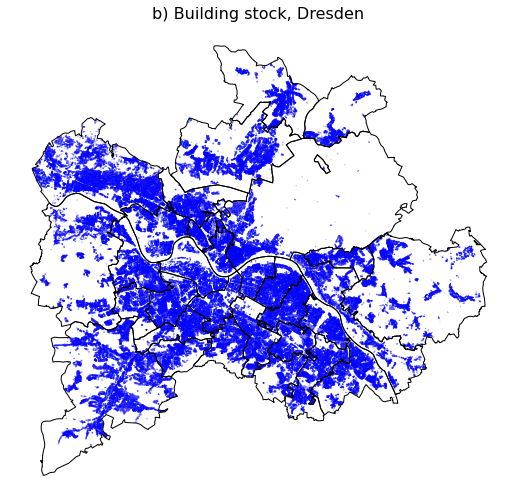

In [20]:
fig, ax = plt.subplots(figsize=(9,9))
buildings_gdf.plot(ax=ax,edgecolor='blue',alpha=0.7)
city_poly.plot(ax=ax,edgecolor='black',facecolor='None')
ax.set_title("b) Building stock, Dresden",size=16)
plt.axis('off'); # this removes the figure frame and the lat/lon coords
plt.savefig('../outputs/LU/LU_demo_Dresden_EUBUCCO.png',facecolor='w',dpi=300,bbox_inches='tight')